In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glhmm.glhmm as glhmm
import seaborn as sns
import network_tools as nt
import importlib
import networkx as nx
import dynamics as dyn
from scipy.linalg import eig
import csv
from sklearn.cluster import KMeans,MiniBatchKMeans
import statespacesplitting as sss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib
import hmm_helper as hmmh

In [115]:
importlib.reload(nt)
importlib.reload(dyn)
importlib.reload(sss)
importlib.reload(hmmh)

<module 'hmm_helper' from '/Users/ramon/Desktop/Year 2/hmm/hmm_helper.py'>

In [3]:
N = 3
W = nt.generate_hierarchical_network(N,mu = 0.2,p0 = 1,recip = 10)

In [4]:
Theta = 1
gamma = 0.1
sigma = 0.05
dt = 0.05
steps = 1000
print(np.real(np.linalg.eig(Theta*(np.diag(np.ones(N))-gamma*W)).eigenvalues)>0)
Phi = dyn.EPR_network_ornstein_uhlenbeck(W,sigma,Theta,gamma)

[ True  True  True]


In [5]:
[X,t] = dyn.network_ornstein_uhlenbeck(nt.parameterise_network(W,1),sigma,Theta,gamma,dt,steps)
tau = 20
X_sampled = X[:,0::tau]
t_sampled= t[0::tau]

/Users/ramon/opt/anaconda3/envs/hmm/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ramon/opt/anaconda3/envs/hmm/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ramon/opt/anaconda3/envs/hmm/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ramon/opt/anaconda3/envs/hmm/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

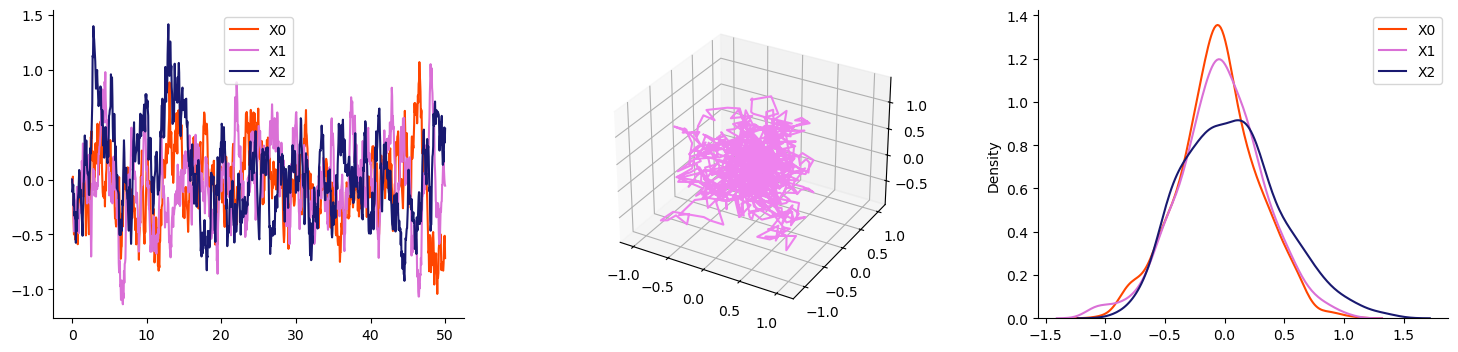

<Figure size 640x480 with 0 Axes>

In [40]:
fig = plt.figure()
axs=[0,0,0]
axs[0] = fig.add_subplot(1,3,1)
axs[1] = fig.add_subplot(1,3,2,projection='3d')
axs[2] = fig.add_subplot(1,3,3)
fig.set_size_inches(18,4)
cols = ['orangered','orchid','midnightblue']
for i in range(0,3):
    sns.lineplot(x=t,y=X[i,:],label = 'X'+str(i),ax=axs[0],color=cols[i])
    sns.despine()
    sns.kdeplot(X[i,:],label='X'+str(i),color=cols[i],ax=axs[2])
axs[1].plot(X[0,:], X[1,:], X[2,:], color = 'violet')
axs[2].legend()
plt.show()
sns.despine()
plt.tight_layout()
plt.show()

In [56]:
box_tc, box_idx_tc = sss.state_space_split(X,3,sss.boundary_list(X,[2,2,2]))

/var/folders/j3/3jf2wkbj5756yfdv4zjq5j300000gn/T/ipykernel_17189/104999942.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


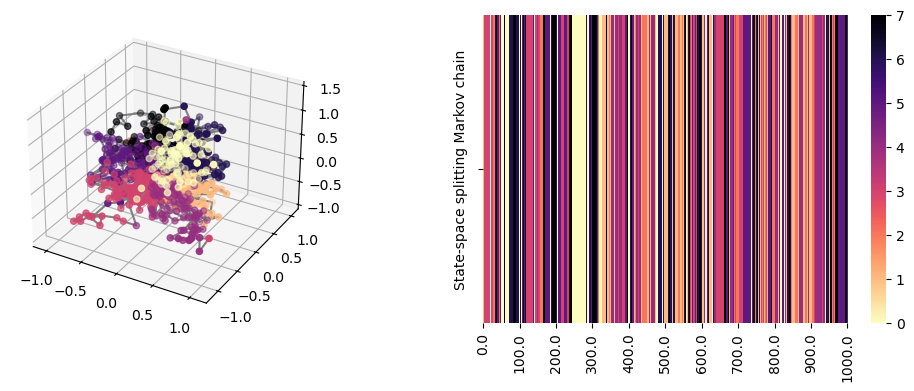

In [99]:
colours =['orangered','orchid','midnightblue','forestgreen','violet','gold','lightblue','black']
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(box_idx_tc)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X[0,np.where(bidx==i)[0]], X[1,np.where(bidx==i)[0]], X[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X[0,], X[1,], X[2,], color = 'grey')
df = pd.DataFrame({"SSS":box_idx_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,1000,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('State-space splitting Markov chain')
plt.show()

In [116]:
hmm = glhmm.glhmm(model_beta='no', K=8, covtype='full')
hmm.train(X=None, Y=np.transpose(X))
hmm_tc = hmmh.vector_time_course_to_tc(hmm.decode(X=None, Y=np.transpose(X),viterbi=True))

Init repetition 1 free energy = 1276.706131328205
Init repetition 2 free energy = 1324.5351095104593
Init repetition 3 free energy = 1320.8636631427685
Init repetition 4 free energy = 1377.912787825303
Init repetition 5 free energy = 1299.1269815673152
Best repetition: 1
Cycle 1 free energy = 1433.1199342830205
Cycle 2 free energy = 1266.4665275901007
Cycle 3, free energy = 1261.5027437574565, relative change = 0.02892358170788688
Cycle 4, free energy = 1258.0940460905297, relative change = 0.019475391338554564
Cycle 5, free energy = 1254.7275170499775, relative change = 0.018871480597487257
Cycle 6, free energy = 1253.4512251974252, relative change = 0.00710358447527022
Cycle 7, free energy = 1252.9152557218733, relative change = 0.002974226195631054
Cycle 8, free energy = 1252.6715013744263, relative change = 0.0013508255157335673
Cycle 9, free energy = 1252.5514573714775, relative change = 0.0006648115163956528
Cycle 10, free energy = 1252.4868834663216, relative change = 0.00035748

/var/folders/j3/3jf2wkbj5756yfdv4zjq5j300000gn/T/ipykernel_17189/842062286.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


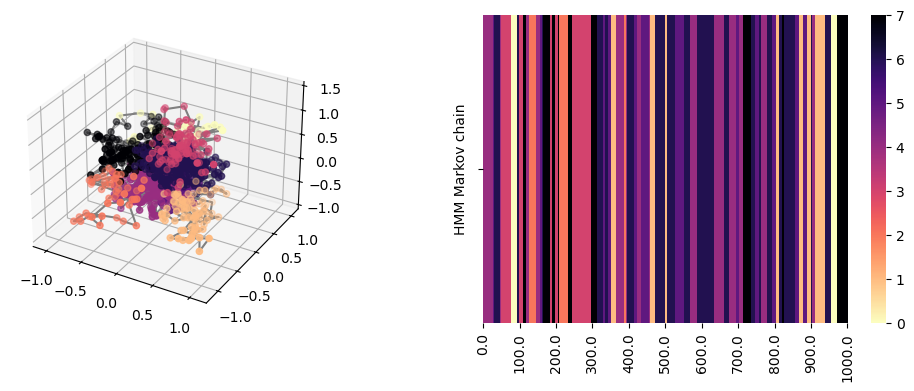

In [118]:
colours =['orangered','orchid','midnightblue','forestgreen','violet','gold','lightblue','black']
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(hmm_tc)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X[0,np.where(bidx==i)[0]], X[1,np.where(bidx==i)[0]], X[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X[0,], X[1,], X[2,], color = 'grey')
df = pd.DataFrame({"SSS":hmm_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,1000,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('HMM Markov chain')
plt.show()